In [1]:
import numpy as np
from random import random
from scipy import optimize as opt
import matplotlib.pyplot as plt
from numpy.random import rand
import seaborn as sbn
from scipy.stats import pearsonr, spearmanr

# Simulation

In [2]:
def simulation_cell_division(N0_cells, T, p_division = 0.1 ):
  #input: N0_cells = number of cells at time t=0
  #       T = number of time step 
  #       p_division = probability of a cell division 
  #output: cell_div_tree: cell_div_tree[c][t] = array of the number of children of the cells at time t-1 of the lineage c
  cell_div_tree = [[[] for i in range(T)] for i in range(N0_cells)]
  for c in range(N0_cells):
    # initialize the cell at time 0
    cell_div_tree[c][0] = np.append(cell_div_tree[c][0], 1)
    for t in range(T-1):
      for iter, i in enumerate(cell_div_tree[c][t]):
        X = random()
        if (X<= p_division):
          # there is a cell division -> number of children = 2
          cell_div_tree[c][t+1] = np.append(cell_div_tree[c][t+1], 2)
        else:
          # there is no cell division -> number of children = 1 (the cell itself)
          cell_div_tree[c][t+1] = np.append(cell_div_tree[c][t+1], 1)
        # if there were 2 cells at time t-1 redo the above steps for the second cell:
        if (i==2):
          X = random()
          if (X<= p_division):
            # there is a cell division -> number of children = 2
            cell_div_tree[c][t+1] = np.append(cell_div_tree[c][t+1], 2)
          else:
            # there is no cell division -> number of children = 1 (the cell itself)
            cell_div_tree[c][t+1] = np.append(cell_div_tree[c][t+1], 1)

  return (cell_div_tree)

In [3]:
def labeling_cells_tree(cells_division_tree):
  #input: cells_division_tree: cells_division_tree[c][t] = array of the number of children of the cells at time t-1 of the lineage c
  #ouptut: labels_tree: labels_tree[c][t] = label of each cell of the lineage c at time t
  #        number_of_cells = number of different label cells
  #        ending_cells = label of all cells which are in the last time step (the one which have no child)  
  N0_cells = len(cells_division_tree)
  T = len(cells_division_tree[0])
  label = 0
  labels_tree = [[[] for i in range(T)] for i in range(N0_cells)]
  ending_cells = np.array([])
  # put label on each cell in a tree format and find the labels of the ending cells
  for c in range(N0_cells):
    for t in range(T):
      for iter, i in enumerate(cells_division_tree[c][t]):
        for j in range(int(i)):
          # add the label 
          labels_tree[c][t] = np.append(labels_tree[c][t], label)
          if (t==T-1):
            # add the label of the cell in ending_cells
            ending_cells = np.append(ending_cells, label)
          label += 1 
  number_of_cells = label
  return labels_tree, number_of_cells, ending_cells


In [4]:
def mother_daughter(cells_division_tree, labels_tree, n_cells):
  #input: cells_division_tree[c][t] = array of the number of children of the cells at time t-1 of the lineage c
  #       labels_tree[c][t] = label of each cell of the lineage c at time t
  #       n_cells = number of different label cells
  #output: mother: mother[i] = label of the mother of cell i (or -1 if it has no mother)
  #       daughter: daughter[i] = label(s) of the child(ren) of cell i
  N0_cells = len(cells_division_tree)
  T = len(cells_division_tree[0])
  mother = -2 * np.ones(n_cells)
  daugthers = {}
  # find the mother of each cell and attribute the cell as the daughter of the mother
  for c in range(N0_cells):
    for t in range(T):
      if (t==0):
        # cells that have no mother (cells at time t=0)
        daughter = labels_tree[c][t][0]
        mother[int(daughter)] = -1
        daugthers[-1] = np.array(daughter)
      else:
        j=0
        for iter, i in enumerate(cells_division_tree[c][t]):
          # update of the mother and the daughter
          daughter = labels_tree[c][t][j]
          mother[int(daughter)] = labels_tree[c][t-1][iter]
          daugthers[labels_tree[c][t-1][iter]] = np.array(daughter)
          j = j+1
          if (i==2):
            # if 2 daughters: re-update the daughters and update the mother
            daughter2 = labels_tree[c][t][j]
            mother[int(daughter2)] = labels_tree[c][t-1][iter]
            daugthers[labels_tree[c][t-1][iter]] = np.array([daughter, daughter2])
            j = j+1

  return mother, daugthers


In [5]:
def lipid_type_proba(proba, n_lipid):
  #input: proba = a vector of probabilities which sum to 1
  #       n_lipids = size of the vector proba
  #output: type_ = type of the lipid randomly according to the probabilities
  X = random()
  s = 0
  for type_ in range(n_lipid):
    s = s + proba[type_]
    if (X <= s):
      return type_

In [6]:
def theta_simulation(theta, mother_daugh, n_lipid = 6):
  #input: theta = transition matrix of the lipid states
  #       mother_daugh: mother_daugh[i]= mother of cell i
  #       n_lipid = number of different lipid state
  #output: lipid_type: lipid_type[:,i] = 0-1 vector where the one represent the lipid state of cell i
  N_cells = mother_daugh.shape[0]
  lipid_type = np.zeros((n_lipid, N_cells))
  starting_cells = np.where(mother_daugh == -1)
  # give a lipid type randomly for each starting cells
  for cell in starting_cells:
    type_ = np.random.randint(0,n_lipid -1)
    lipid_type[type_, cell] = 1
  
  # find the lipid type of the others cells
  knowing_cells = starting_cells
  iter = 0
  while (iter < len(knowing_cells)):
    mother = knowing_cells[iter]
    daughters = np.where(mother_daugh == mother)
    if (len(daughters) != 0):
      proba_type = lipid_type[:, mother].T @ theta
      proba_type = proba_type.reshape(-1,1)
      for d in daughters:
        # find the lipid type of each daughter randomly accordingly to the probabilities (proba_type)
        type_ = lipid_type_proba(proba_type, n_lipid)
        lipid_type[type_, d] = 1
        knowing_cells = np.append(knowing_cells, d)
    iter = iter + 1

  return lipid_type


In [7]:
def simulation(N0_cells, T, theta, p_division = 0.1, n_lipid = 6):
  # do the cell division simulation, find the mother and daughter link 
  # and find the lipid state for each cells with respect to the lipid transition matrix theta
  cell_div_tree = simulation_cell_division(N0_cells, T, p_division)
  label_tree, n_cells, end_cells = labeling_cells_tree(cell_div_tree)
  mother_of_daughter, daugther_dict = mother_daughter(cell_div_tree, label_tree, n_cells)
  lipid_cells = theta_simulation(theta, mother_of_daughter, n_lipid)
  return lipid_cells, mother_of_daughter, end_cells, daugther_dict
  

# Functions of the optimization : updating Q and Theta

In [8]:
def compute_M_and_Z(lipid_cells,end_cells,mother_of_daughter):
    K=lipid_cells.shape[0]
    M=np.zeros([K,len(end_cells)])
    Z=M.copy()
    lipid_cells[:,0]
    for iter,i in enumerate(end_cells):
        M[:,iter]=lipid_cells[:,int(i)]
        Z[:,iter]=lipid_cells[:,int(mother_of_daughter[int(i)])]

    return M, Z, K

In [9]:
def compute_Zd_and_Zm(lipid_cells, end_cells, mother_of_daughter):
  K=lipid_cells.shape[0]
  N_cells = lipid_cells.shape[1]
  N_big_mothers = len(mother_of_daughter[mother_of_daughter == -1])
  mothers_of_end_cells = np.array([int(mother_of_daughter[int(i)]) for i in end_cells])
  Zd=np.zeros([K,N_cells-len(end_cells)-N_big_mothers])
  Zm=Zd.copy()
  Z_in_Zd=np.zeros(len(end_cells)) ; Z_in_Zd_idx = 0
  iter = 0
  for d, m in enumerate(mother_of_daughter):
    if (d not in end_cells and m!=-1):
      Zd[:,iter]=lipid_cells[:,int(d)]
      Zm[:,iter]=lipid_cells[:,int(m)]
      iter = iter + 1

  return Zd, Zm #, Z_in_Zd

In [10]:
def get_all_mothers(indexes, shift=0):
  return np.array([mother_of_daughter[int(i)]+shift for i in indexes])

def matrix_k(vec, k):
    #take a vector v and an int k, return a square matrix with v at the k^th column
    K=len(vec)
    matrix=np.zeros((K,K))
    matrix[:,k]=vec
    return matrix
#define a new log
def _log(r):
    return np.log(np.abs(r))

In [11]:
def compute_Q(Theta_vert, M, Zd, Zm, Z, lipid_cells, mother_of_daughter, daugther_dict, end_cells,  pi_k, K):
    Theta_matrix=Theta_vert.reshape(K,K)
    sum_i=0
    sum_u=0
    Qki=np.ones((len(end_cells), N_state))*0.5
    Qku=np.ones((Zd.shape[1], N_state))*0.5
    
    mothers_of_end_cells = np.array([int(mother_of_daughter[int(i)]) for i in end_cells])
    idx_mother = np.unique(mothers_of_end_cells, return_counts=True)[0]
    n_daughters_per_mother = np.unique(mothers_of_end_cells, return_counts=True)[1]
    # Attribution of values in Qki
    for iter, cell in enumerate(idx_mother):
      n_daugther = n_daughters_per_mother[iter]
      if n_daugther == 1:
        idx = np.where(mothers_of_end_cells == idx_mother[iter])[0][0]
        sum_k=0
        for k in range(N_state):
          sum_k += (M[:,idx].T @ Theta_matrix)[k] * Z[k,idx] * pi_k[k]
        for k in range(N_state):
          Qki[idx, k] = ((M[:,idx].T @ Theta_matrix)[k] * Z[k,idx] * pi_k[k]) / sum_k 
      if n_daugther == 2:
        idx_daugther = np.where(mothers_of_end_cells == idx_mother[iter])[0]
        d1_idx = idx_daugther[0]
        d2_idx = idx_daugther[1]
        d1 = M[:,d1_idx].copy()
        d2 = M[:,d2_idx].copy()
        sum_k=0 ; sum_k1=0 ; sum_k2=0
        for k in range(N_state):
          P_d1_knowing_Zisk = (d1.T @ Theta_matrix)[k] * Z[k,d1_idx]
          P_d2_knowing_Zisk = (d2.T @ Theta_matrix)[k] * Z[k,d2_idx]
          sum_k += P_d1_knowing_Zisk * P_d2_knowing_Zisk * pi_k[k]
          #sum_k1 += (d1.T @ Theta_matrix)[k] * Z[k,d1_idx] * pi_k[k]
          #sum_k2 += (d2.T @ Theta_matrix)[k] * Z[k,d2_idx] * pi_k[k]
        for k in range(N_state):
          P_d1_knowing_Zisk = (d1.T @ Theta_matrix)[k] * Z[k,d1_idx]
          P_d2_knowing_Zisk = (d2.T @ Theta_matrix)[k] * Z[k,d2_idx]
          Qki[d1_idx, k] = (P_d1_knowing_Zisk * P_d2_knowing_Zisk * pi_k[k]) / sum_k #* pi_k[k]
          Qki[d2_idx, k] = (P_d1_knowing_Zisk * P_d2_knowing_Zisk * pi_k[k]) / sum_k #* pi_k[k]

    # Attribute Qki to Qku for the overlaping cells (mothers of M in Qki are the youngest daughters in Qku)
    mother_of_end_cells = [mother_of_daughter[int(i)] for i in end_cells]
    min_mothers = min(mother_of_end_cells)
    n_uniq = len(np.unique(mother_of_end_cells))
    idx_new_array = mother_of_end_cells - min_mothers
    new_array = np.zeros((n_uniq, N_state))
    for i, idx in enumerate(idx_new_array):
      new_array[int(idx),:] = Qki[i,:]
    Qku_start = min_mothers - 1
    Qku_end = min_mothers - 1 + n_uniq
    it = 0 
    for i in range(int(Qku_start), int(Qku_end)):
      Qku[i,:] = new_array[it,:] 
      it += 1

    # Iterative attribution of Qku from the leaf to the root of the tree
    next_mothers = mothers_of_end_cells
    no_big_mother=True
    while(no_big_mother):
      next_mothers = np.array([int(mother_of_daughter[int(i)]) for i in np.unique(next_mothers)])      
      idx_mother = np.unique(next_mothers, return_counts=True)[0]
      n_daughters_per_mother = np.unique(next_mothers, return_counts=True)[1]
      # Iterate over all the mothers found
      for iter, cell in enumerate(idx_mother):
        if cell > -1:
          n_daugther = n_daughters_per_mother[iter]
          # Consider the case where one daughter is found
          if n_daugther == 1:
            #idx = np.where(mother_of_daughter == cell)[0][0]
            idx = int(daugther_dict[cell])
            sum_k=0
            for k in range(N_state):
              sum_k += (Zd.T[idx-1,:].T @ Theta_matrix)[k] * Zm[k,idx-1] #* pi_k[k]
            for k in range(N_state):
              Qku[cell-1, k] = ((Zd.T[idx-1,:].T @ Theta_matrix)[k] * Zm[k,idx-1] ) / sum_k #* pi_k[k]
          # Consider the case where two daughters are found
          if n_daugther > 1:
            idx_daugther = daugther_dict[cell]
            d1_idx = int(idx_daugther[0])-1
            d2_idx = int(idx_daugther[1])-1
            d1 = Zd.T[d1_idx,:].copy()
            d2 = Zd.T[d2_idx,:].copy()
            sum_k=0 ; sum_k1=0 ; sum_k2=0 
            for k in range(N_state):
              P_d1_knowing_Zisk = (d1.T @ Theta_matrix)[k] * Zm[k,d1_idx]
              P_d2_knowing_Zisk = (d2.T @ Theta_matrix)[k] * Zm[k,d2_idx]
              sum_k += P_d1_knowing_Zisk * P_d2_knowing_Zisk  * pi_k[k]
            for k in range(N_state):
              P_d1_knowing_Zisk = (d1.T @ Theta_matrix)[k] * Zm[k,d1_idx]
              P_d2_knowing_Zisk = (d2.T @ Theta_matrix)[k] * Zm[k,d2_idx]
              Qku[cell-1, k] = ( P_d1_knowing_Zisk * P_d2_knowing_Zisk  * pi_k[k] )/ sum_k

      no_big_mother = -1 not in next_mothers

    return Qki, Qku

In [12]:
def launch_simulation_and_EM(N_clades, T, p, Theta_0):
    
    K = N_state
    # theta_{i,j} >= 0 for all i,j
    ID = np.eye(K*K)
    linear_constraint1 = opt.LinearConstraint(ID, np.zeros(K*K), np.inf * np.ones(K*K))

    # theta*1 = 1
    A = np.zeros(K*K*K)
    A = A.reshape(K,K*K)
    for i in range(K):
      A[i, (i*K): ((i+1)*K)] = 1

    one_vec = np.ones(K)
    linear_constraint2 = opt.LinearConstraint(A, one_vec, one_vec)
 
    #N_clades = 20
    lipid_cells_l, mother_of_daughter_l, end_cells_l, daugther_dict_l = [], [], [], []
    for i in range(N_clades):
      lipid_cells, mother_of_daughter, end_cells, daugther_dict = simulation(N0_cells = 1, T = 8, theta = theta_rand, 
                                                                                        p_division = 0.8, n_lipid = N_state)
      lipid_cells_l.append(lipid_cells) ; mother_of_daughter_l.append(mother_of_daughter)
      end_cells_l.append(end_cells) ; daugther_dict_l.append(daugther_dict)
    
    # initialize Theta 
    Theta_0_vert=(Theta_0).reshape(K*K)

    # Compute prior distribution based on observed states
    #pi_k_0 = np.zeros((N_state, 1))
    #for k in range(N_state):
    #  pi_k_0[k] = np.sum(M[k,:]) / M.shape[1]

    # Or simply set pi to equiproba
    pi_k_0 = np.repeat(1/N_state, N_state)
    pi_k = pi_k_0.copy()
    
    # with multiple clades :
    M_l, Z_true_l = [], []
    Zd_true_l, Zm_true_l = [], []
    Qki_l, Qku_l = [], []
    Zd_0_l, Zm_0_l = [], []
    Z_0_l = []

    for i in range(N_clades):
      lipid_cells = lipid_cells_l[i] ; end_cells = end_cells_l[i]
      mother_of_daughter = mother_of_daughter_l[i]
      daugther_dict = daugther_dict_l[i]
      M,Z_true,K=compute_M_and_Z(lipid_cells,end_cells,mother_of_daughter)
      Zd_true, Zm_true = compute_Zd_and_Zm(lipid_cells,end_cells,mother_of_daughter)

      M_l.append(M) ; Z_true_l.append(Z_true)
      Zd_true_l.append(Zd_true) ; Zm_true_l.append(Zm_true)

      # INITIALIZE Zs with prior distribution
      Zd_0 = np.ones((Zd_true.shape[0], Zd_true.shape[1]))
      Zm_0 = np.ones((Zm_true.shape[0], Zm_true.shape[1]))
      Z_0 = np.ones((Z_true.shape[0], Z_true.shape[1]))
      for k in range(N_state):
        Zd_0[k,:] = Zd_0[k,:] * pi_k_0[k]
        Zm_0[k,:] = Zm_0[k,:] * pi_k_0[k]
        Z_0[k,:] = Z_0[k,:] * pi_k_0[k]

      Zd_0_l.append(Zd_0) ; Zm_0_l.append(Zm_0)
      Z_0_l.append(Z_0)

      Zd = Zd_0.copy()
      Zm = Zm_0.copy()
      Z = Z_0.copy()
      [Qki_0,Qku_0]=compute_Q(Theta_0_vert, M, Zd, Zm, Z, lipid_cells, mother_of_daughter, daugther_dict, end_cells,  pi_k, K)
      Qki_l.append(Qki_0) ; Qku_l.append(Qku_0)
    
    # init theta 
    Theta_0_vert=(Theta_0).reshape(K*K)

    ### REPEAT CODE WITH MULTIPLE CLADES
    maxiter=50
    Theta_vert=Theta_0_vert.copy()
    pi_k = pi_k_0.copy()

    # Init Z per clade 
    Z_l, Zm_l, Zd_l = [], [], []
    Qki_l, Qku_l = [], []
    for i in range(N_clades):
      Z_l.append(Z_0_l[i])
      Zm_l.append(Zm_0_l[i])
      Zd_l.append(Zd_0_l[i])
      Qki_l.append(0)
      Qku_l.append(0)

    #stop the loop if the difference between two following answers are close enough
    tol=1e-3
    diff=10000
    iter=0
    obj_f_iterations=[]
    save_theta = []
    isnan=False

    while iter<maxiter and diff>tol and not isnan:
      print("\nEM step ", iter)

      #### E-step : Define Q #### 
      for i in range(N_clades):
        M = M_l[i].copy()
        Zd = Zd_l[i].copy()
        Zm = Zm_l[i].copy()
        Z = Z_l[i].copy()
        lipid_cells = lipid_cells_l[i] ; end_cells = end_cells_l[i]
        mother_of_daughter = mother_of_daughter_l[i]
        daugther_dict = daugther_dict_l[i]
        [Qki,Qku]=compute_Q(Theta_0_vert, M, Zd, Zm, Z, lipid_cells, mother_of_daughter, daugther_dict, end_cells, pi_k, K)
        Qki_l[i] = Qki
        Qku_l[i] = Qku

      # Diff between old Qs and new ones
      #print("Diff w.r.t Qku : ", str(np.linalg.norm(Qku.flatten()-old_Qku.flatten())))

      def f(Theta_vert): #power of theta = 1
          Theta_matrix=Theta_vert.reshape(K,K) 

          #Careful that M and Z are well defined above it
          #Careful that Q is given above
          likelihood=0;
          jac_i=np.zeros([K,K])
          jac_u=np.zeros([K,K])

          #sum over i and k
          for i in range(N_clades):
            Qki = Qki_l[i].copy()
            for idx in range(Qki.shape[0]):
              #Qki = Qki_l[i].copy()
              Qk = Qki[idx,:]
              # redo using Qik : 
              for k in range(N_state):
                Z = Z_l[i].copy()
                M = M_l[i].copy()
                q = Qk[k]
                if np.abs(q) > 1e-10:
                  likelihood += q * _log( (M[:,idx].T @ Theta_matrix)[k] * Z[k,idx] * pi_k[k]) #* pi_k[k] 
                  jac_i+=q/((M[:,idx].T @ Theta_matrix)[k])*matrix_k(M[:,idx],k)


          for i in range(N_clades):
            Zm = Zm_l[i].copy()
            Zd = Zd_l[i].copy()
            Qku = Qku_l[i].copy()
            for idx in range(Qku.shape[0]):
              Qk = Qku[idx,:]
              # redo using Qik : 
              for k in range(N_state):
                q = Qk[k]
                if np.abs(q) > 1e-10:
                  likelihood += q * _log( (Zd[:,idx].T @ Theta_matrix)[k] * Zm[k,idx] * pi_k[k]) #* pi_k[k] 
                  jac_u+=q/((Zd[:,idx].T @ Theta_matrix)[k])*matrix_k(Zd[:,idx],k)

          jac=jac_i+jac_u
          jac=jac.reshape(K*K)
          return [-likelihood,-jac]

      #### M-STEP : optimize Theta and update Z and pi #### 
      res = opt.minimize(f, Theta_vert, method='trust-constr', constraints=[linear_constraint1, linear_constraint2], jac=True)

      diff=np.linalg.norm(Theta_vert-res.x)
      Theta_vert=res.x

      print("Difference in between two steps : ", diff)
      print("Theta* : \n",res.x.reshape(K,K))
      obj_f_iterations.append(res.fun)
      iter=iter+1

      # update z WRT Q:
      for r in range(N_clades):
        Zd = Zd_l[r].copy()
        Qku = Qku_l[r].copy()
        Qki = Qki_l[r].copy()
        Zm = Zm_l[r].copy()
        Z = Z_l[r].copy()
        Zm = Qku.T.copy()
        Z = Qki.T.copy()
        lipid_cells = lipid_cells_l[r] ; end_cells = end_cells_l[r]
        mother_of_daughter = mother_of_daughter_l[r]
        daugther_dict = daugther_dict_l[r]
        for idx, c in enumerate(sorted(daugther_dict.keys())):
          daugther = daugther_dict[c]
          if daugther.ndim > 0:
            for d in daugther:
              if d not in end_cells:
                Zd[:,int(d)-1] = Qku.T[:,int(c)-1]
          else:
            if daugther not in end_cells:
              Zd[:,int(daugther)-1] = Qku.T[:,int(c)-1]

        # Update last Zd values - corresponds to Z vals
        mother_of_end_cells = [mother_of_daughter[int(i)] for i in end_cells]
        min_mothers = min(mother_of_end_cells)
        n_uniq = len(np.unique(mother_of_end_cells))
        idx_new_array = mother_of_end_cells - min_mothers
        new_array = np.zeros((n_uniq, N_state))
        for i, idx in enumerate(idx_new_array):
          new_array[int(idx),:] = Qki.T[:,i]
        Zd_start = min_mothers - 1
        Zd_end = min_mothers - 1 + n_uniq
        it = 0 
        for i in range(int(Zd_start), int(Zd_end)):
          Zd[:,i] = new_array[it,:] 
          it += 1

        # update values in list :
        Zd_l[r] = Zd
        Zm_l[r] = Zm
        Z_l[r] = Z
        if np.any(np.isnan(Qku)):
          isnan=True

      # Redifine pi
      #for k in range(K):
      #  pi_k[k] = (np.sum(Qku[:,k]) + np.sum(M[k,:])) / (np.sum(Qku) + np.sum(M))

      error = np.linalg.norm(Theta_vert - theta_rand.flatten())
      corr = pearsonr(Theta_vert, theta_rand.flatten())[0]
      obj = res.fun

      # Keep record of Qku and Qki at step t-1
      old_Qku = Qku.copy() ; old_Qki = Qki.copy()
      save_theta.append(Theta_vert.reshape(K,K)) 

    return(error, corr, obj, save_theta)

    Theta_final = Theta_vert.reshape(K,K)
    print("\n------------------------------------------------------")
    print("FINAL RESULT: \n", Theta_final)
    print("Theta used in the simulation: \n", theta_rand)
    print("with difference in between two steps of : ", diff)

### Definition of Theta

we define the true Theta and the initial Theta_0

<AxesSubplot:>

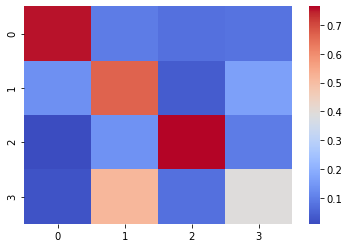

In [13]:
N_state = 4
K = N_state
# Use random number generator with stronger values on the diagonal
theta_rand = rand(N_state,N_state) + 3*np.identity(N_state)
# let's add manually one strong transition somewhere :
theta_rand[3,1] = 5

# normalize by row : 
theta_rand = np.array([theta_rand[i,:] / theta_rand.sum(axis=1)[i] for i in range(theta_rand.shape[0])])
sbn.heatmap(theta_rand, cmap='coolwarm')

In [14]:
# Define Theta 0 
Theta_0 = 1000*np.identity(N_state) + rand(N_state,N_state) # Add noise
Theta_0 = np.array([Theta_0[i,:] / Theta_0.sum(axis=1)[i] for i in range(Theta_0.shape[0])])

In [ ]:
# Launch the Expectation-Maximization algorithm to predict Theta,
# Here for 5 Clades (N), 10 generations (T) and a division probability of 0.8
e, c, o, thetas = launch_simulation_and_EM(N_clades=10, T=10, p=0.8, Theta_0 = Theta_0)


EM step  0
Difference in between two steps :  0.00337854155863216
Theta* : 
 [[9.99840350e-01 1.19392783e-04 1.76100868e-05 2.26476295e-05]
 [1.21067796e-05 9.99843244e-01 4.59104651e-05 9.87383759e-05]
 [9.57679635e-05 3.00773752e-04 9.99575489e-01 2.79694856e-05]
 [8.90958247e-05 1.74095269e-04 8.53762100e-05 9.99651433e-01]]

EM step  1
Difference in between two steps :  0.013895319200884371
Theta* : 
 [[0.99409188 0.00223949 0.00184702 0.00182161]
 [0.00323115 0.99083689 0.00305013 0.00288182]
 [0.00135765 0.00165448 0.99574064 0.00124723]
 [0.00136794 0.00167904 0.00127389 0.99567912]]

EM step  2


Text(0.5, 1.0, 'True Theta')

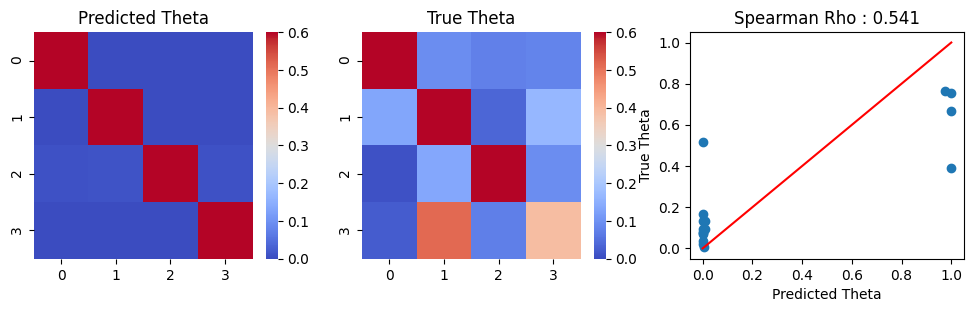

In [18]:
import seaborn as sbn ; from scipy.stats import pearsonr, spearmanr
x=1#len(thetas)-1
fig, axs = plt.subplots(1,3,figsize=(12,3), dpi=100)
sbn.heatmap(thetas[x], ax=axs[0], vmin=0, vmax=0.6, cmap='coolwarm')
# compare prediction with ground truth
sbn.heatmap(theta_rand, ax=axs[1], vmin=0, vmax=0.6, cmap='coolwarm')
max_val = max(max(thetas[x].flatten()), max(theta_rand.flatten()))
axs[2].plot([0,max_val], [0,max_val], c='r')
axs[2].scatter(thetas[x].flatten(), theta_rand.flatten())
axs[2].set_xlabel('Predicted Theta')
axs[2].set_ylabel('True Theta')
axs[2].set_title("Spearman Rho : " + str(round(spearmanr(thetas[x].flatten(), theta_rand.flatten())[0], ndigits=3)))
axs[0].set_title('Predicted Theta')
axs[1].set_title('True Theta')
# add comparison between prediction and Theta_0

We then rerun it with multiple conditions 
WARNING this takes time to compute !

In [ ]:
error_all = []
obj_all = []
corr_all = []
for N in range(1,10):
    error, obj, corr = [], [], []
    for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        e, c, o = launch_simulation_and_EM(N_clades=N, T=5, p=p, Theta_0 = Theta_0)
        error.append(e)
        corr.append(c)
        obj.append(o)
    error_all.append(error)
    obj_all.append(obj)
    corr_all.append(corr)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,3), dpi=300)
sbn.heatmap(error_all, cmap ='turbo', ax=axs[0], xticklabels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            yticklabels=range(1,10))
sbn.heatmap(corr_all, cmap ='turbo', ax=axs[1], xticklabels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            yticklabels=range(1,10))
plt.show()